### Test Model

In [2]:
"""
Created on Tuesday 3 April 2022
Author: ZMW
"""
#import libraries

import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import GradientBoostingClassifier
from numpy import mean
from numpy import std
from xgboost import plot_importance
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import shap

In [3]:
#Load the fitted dataset
data = pd.read_csv('data.csv')

In [4]:
data.head()

,Label,Patient,A1_1Deg,A1_1Deg_err,B1_1Deg,B1_1Deg_err,C1_1Deg,C1_1Deg_err,1_Deg_ResSoS_1,1Deg_AdjR2_1,...,8_Deg_ResSoS_1,8Deg_AdjR2_1,A2_8Deg,A2_8Deg_err,B2_8Deg,B2_8Deg_err,C2_8Deg,C2_8Deg_err,8_Deg_ResSoS_2,8Deg_AdjR2_2
0,Not_Parkinson's,PD001,10.388190,0.006132,0.049329,0.000006,0.011989,0.000337,8928.709194,0.990598,...,6698.838281,0.951413,10.273124,0.044206,0.386347,0.000384,0.037356,0.002439,6809.455800,0.939095
1,Not_Parkinson's,PD002,10.429055,0.006929,0.049478,0.000007,0.002837,0.000379,11388.604704,0.988092,...,4769.901822,0.967360,11.482500,0.049154,0.395412,0.000380,-0.002486,0.002419,8383.481840,0.939586
2,Not_Parkinson's,PD003,10.097088,0.005091,0.049368,0.000006,0.005707,0.000287,6140.292312,0.993141,...,3488.747176,0.968709,10.084338,0.019838,0.394595,0.000174,-0.035466,0.001106,1349.962240,0.987259
3,Not_Parkinson's,PD004,10.482881,0.022179,0.049585,0.000023,0.016056,0.001212,117748.979710,0.879372,...,10972.045844,0.920137,11.493414,0.048867,0.401386,0.000377,-0.042463,0.002395,8242.136178,0.940370
4,Not_Parkinson's,PD005,10.181273,0.008833,0.049368,0.000010,0.001569,0.000494,18447.340517,0.979692,...,18268.960666,0.809586,10.370348,0.036121,0.395392,0.000308,-0.030769,0.001960,4485.300264,0.960035


In [27]:
# Features and labels
x = data.iloc[:,2:]
y = data.iloc[:,0].values

In [28]:
## Convert the categorical variables to number
LabelEncoder_gender = LabelEncoder()
y = LabelEncoder_gender.fit_transform(y)

In [29]:
# Rescale feature
def scale(col):
    return (col - np.min(col))/(np.max(col)-np.min(col))

x = x.apply(scale,axis=0)

In [30]:
# spliting feature
x_train, x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

## GB

In [31]:
import xgboost as xgb
classifier = GradientBoostingClassifier()
classifier.fit(x_train,y_train)


y_pred = classifier.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy score:',accuracy)
precision = metrics.precision_score(y_test,y_pred)
print("Precision score:",precision)
recall = metrics.recall_score(y_test, y_pred)
print('Recall Score:',recall)

[[2 2]
 [2 3]]
Accuracy score: 0.5555555555555556
Precision score: 0.6
Recall Score: 0.6


In [33]:
pipeline = make_pipeline(classifier)
#
# Pass instance of pipeline and training and test data set
# cv=10 represents the StratifiedKFold with 10 folds
#
scores = cross_val_score(pipeline, X=x, y=y, cv=10, n_jobs=1)
 
print('Cross Validation accuracy scores: %s' % scores)
 
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores: [0.33333333 0.33333333 0.66666667 1.         0.66666667 0.66666667
 1.         1.         0.66666667 1.        ]
Cross Validation accuracy: 0.733 +/- 0.249


### Hyperparameter Tuning

In [14]:
params = {'learning_rate':hp.uniform('learning_rate',0.01,0.2),'gamma':hp.uniform('gamma',0,0.2),'min''n_estimators':hp.choice('n_estimators',[50, 100, 200, 300, 400, 500, 1000]),
                    'subsample':hp.uniform('subsample',0.7,1.0),'max_depth':hp.uniform('max_depth',3,10),'min_samples_split':hp.uniform('min_samples_split',0.1,1.0),
                    'min_samples_leaf':hp.uniform('min_samples_leaf',0.1,0.5)}

In [17]:
def hyperparameter_tuning(params):
    clf=GradientBoostingClassifier(**params,random_state=1)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, pred>0.5)
#     print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [18]:
trials = Trials()

best_hyperparams = fmin(fn = hyperparameter_tuning,
                        space = params,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

job exception: __init__() got an unexpected keyword argument 'gamma'



  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]


TypeError: __init__() got an unexpected keyword argument 'gamma'

In [65]:
best_hyperparams

{'colsample_bytree': 0.8108156598807947,
 'gamma': 3.033045815630965,
 'max_depth': 4,
 'min_child_weight': 4.0,
 'reg_alpha': 120.0,
 'reg_lambda': 0.8918473719970311}

In [66]:
best_model = xgb.XGBClassifier( max_depth = best_hyperparams['max_depth'],
                             gamma = best_hyperparams['gamma'],reg_alpha = best_hyperparams['reg_alpha'],
                             reg_lambda = best_hyperparams['reg_lambda'],
                             min_child_weight=best_hyperparams['min_child_weight'],
                             colsample_bytree= best_hyperparams['colsample_bytree'],use_label_encoder=False,eval_metric='mlogloss')
    

In [67]:
best_model.fit(x_train,y_train)
y_pred = best_model.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy score:',accuracy)
precision = metrics.precision_score(y_test,y_pred)
print("Precision score:",precision)
recall = metrics.recall_score(y_test, y_pred)
print('Recall Score:',recall)

[[4 0]
 [5 0]]
Accuracy score: 0.4444444444444444
Precision score: 0.0
Recall Score: 0.0


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [68]:
splits = 50
def run_best_model(arg):
    # data set preparation
    # data = pd.read_csv('data.csv')
    data = arg

    ## Convert the categorical variables to number
    LabelEncoder_gender = LabelEncoder()
    data['Label'] = LabelEncoder_gender.fit_transform(data['Label'])
    
    # run 50 repetitions
    all_set = []
    for split in range(1,splits+1):
        seed = split

        # data set preparation
        train , test = train_test_split(data,train_size = 0.7,shuffle=True,random_state = seed)

        # training set
        data_tra_x = train.iloc[:,2:].values
        data_tra_y = train.iloc[:,0].values

        # test set
        data_tes_x = test.iloc[:,2:].values
        data_tes_y =  test.iloc[:,0].values

        best_model = xgb.XGBClassifier( max_depth = best_hyperparams['max_depth'],
                             gamma = best_hyperparams['gamma'],reg_alpha = best_hyperparams['reg_alpha'],
                             reg_lambda = best_hyperparams['reg_lambda'],
                             min_child_weight=best_hyperparams['min_child_weight'],
                             colsample_bytree= best_hyperparams['colsample_bytree'],use_label_encoder=False,eval_metric='mlogloss')
    
        best_model.fit(data_tra_x,data_tra_y)

        # training error
        tra_pred = best_model.predict(data_tra_x)
        tra_results = [split,'tra',metrics.accuracy_score(data_tra_y,tra_pred)]

        # testing error
        tes_pred = best_model.predict(data_tes_x)
        tes_results = [' ','tes',metrics.accuracy_score(data_tes_y,tes_pred)]

        all_set += tra_results,tes_results

    all_set_df = pd.DataFrame(all_set,columns=['split','set','acc'])

    print('train accuracy',all_set_df[all_set_df['set'] == 'tra']['acc'].mean(),'with std', all_set_df[all_set_df['set'] == 'tra']['acc'].std())
    print('test accuracy',all_set_df[all_set_df['set'] == 'tes']['acc'].mean(),'with std', all_set_df[all_set_df['set'] == 'tes']['acc'].std())

#run_best_model(data)

In [53]:
run_best_model(data)

train accuracy 0.4910000000000001 with std 0.07191973984652501
test accuracy 0.46444444444444444 with std 0.15982164410338892


In [745]:
# cross validation
pipeline = make_pipeline(StandardScaler(), classifier)
#
# Pass instance of pipeline and training and test data set
# cv=10 represents the StratifiedKFold with 10 folds
#
scores = cross_val_score(pipeline, X=x, y=y, cv=10, n_jobs=1)
 
print('Cross Validation accuracy scores: %s' % scores)
 
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores: [1.         0.33333333 0.66666667 0.66666667 0.33333333 0.66666667
 0.66666667 1.         0.66666667 1.        ]
Cross Validation accuracy: 0.700 +/- 0.233


In [239]:
#confusion matrix
confusion = confusion_matrix(y_pred,y_test)
print(confusion)

#  Sensitivity 
TP = confusion[1,1] # true positives
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # False positives
FN = confusion[1,0] # false negatives

sensitivity = TP/float(TP+FN)
print(sensitivity)

# Specificity
specificity = TN/float(TN+FP)
print(specificity)


auc_score = roc_auc_score(y_test, y_pred)
fpr , tpr , thresholds = roc_curve (y_test, y_pred)
print(auc_score)

[[4 1]
 [0 4]]
1.0
0.8
0.9


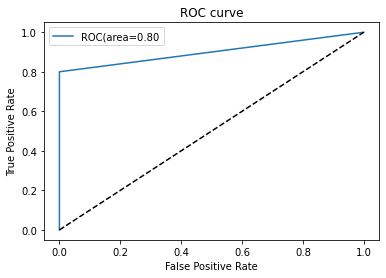

In [240]:
def plot_roc_curve(fpr,tpr): 
  random_probs = [0 for i in range(len(y_test))]
  p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
  plt.plot(fpr,tpr,label='ROC(area=0.80')
  plt.plot(p_fpr, p_tpr,'--',color='black') 
  plt.axis([-0.05,1.05,-0.05,1.05]) 
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.legend()
  #plt.savefig('roc_curve.png',dpi=300)
  plt.show()    
  
plot_roc_curve (fpr,tpr)

In [31]:
# cross validation
pipeline = make_pipeline(StandardScaler(), xgb.XGBClassifier( max_depth = best_hyperparams['max_depth'],
                             gamma = best_hyperparams['gamma'],reg_alpha = best_hyperparams['reg_alpha'],
                             reg_lambda = best_hyperparams['reg_lambda'],
                             min_child_weight=best_hyperparams['min_child_weight'],
                             colsample_bytree= best_hyperparams['colsample_bytree'],use_label_encoder=False,eval_metric='mlogloss'))
#
# Pass instance of pipeline and training and test data set
# cv=10 represents the StratifiedKFold with 10 folds
#
scores = cross_val_score(pipeline, X=x_train, y=y_train, cv=10, n_jobs=1)
 
print('Cross Validation accuracy scores: %s' % scores)
 
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores: [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
Cross Validation accuracy: 0.500 +/- 0.000


In [183]:
cv = LeaveOneOut()
y_true, y_pred = list(), list()
for train_ix, test_ix in cv.split(x):
	# split data
	X_train, X_test = x[train_ix, :], x[test_ix, :]
	y_train, y_test = y[train_ix], y[test_ix]
	# fit model
	model = RandomForestClassifier(random_state=1)
	model.fit(X_train, y_train)
	# evaluate model
	yhat = model.predict(X_test)
	# store
	y_true.append(y_test[0])
	y_pred.append(yhat[0])
# calculate accuracy
acc = accuracy_score(y_true, y_pred)
print('Accuracy: %.3f' % acc)

Accuracy: 0.586


### Feature importance

[]

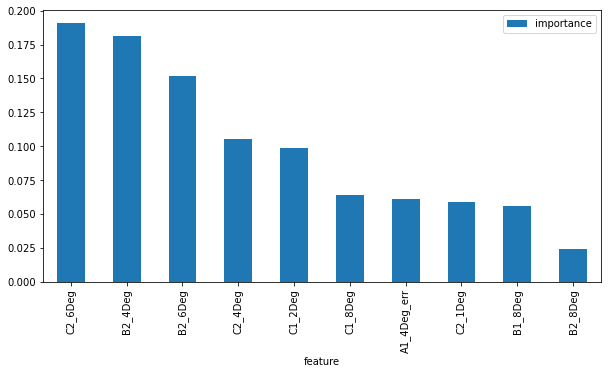

In [26]:
# Feature importance
X_training = data.drop(['Label', 'Patient'], axis = 1).copy()
importances = pd.DataFrame({'feature':X_training.columns,'importance':np.round(classifier.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances = importances[0:10]
importances.plot.bar(figsize=(10,5))
plt.plot()

In [27]:
x = data[['C2_6Deg','B2_4Deg','B2_6Deg','C2_4Deg','C1_2Deg','C1_8Deg','A1_4Deg_err','C2_1Deg','B1_8Deg','B2_8Deg']].values
y = data.iloc[:,0].values

LabelEncoder_gender = LabelEncoder()
y = LabelEncoder_gender.fit_transform(y)

x_train, x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)
classifier = RandomForestClassifier(random_state=3)
classifier.fit(x_train,y_train)
y_pred = classifier.predict(x_test)

cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy score:',accuracy)
precision = metrics.precision_score(y_test,y_pred)
print("Precision score:",precision)
recall = metrics.recall_score(y_test, y_pred)
print('Recall Score:',recall)

[[4 0]
 [1 4]]
Accuracy score: 0.8888888888888888
Precision score: 1.0
Recall Score: 0.8


In [29]:
data = data[['Label','Patient','C2_6Deg','B2_4Deg','B2_6Deg','C2_4Deg',
            'C1_2Deg','C1_8Deg','A1_4Deg_err','C2_1Deg','B1_8Deg','B2_8Deg']]

splits = 100
def run_best_model(arg):
    # data set preparation
    # data = pd.read_csv('data.csv')
    data = arg

    ## Convert the categorical variables to number
    LabelEncoder_gender = LabelEncoder()
    data['Label'] = LabelEncoder_gender.fit_transform(data['Label'])
    
    # run 50 repetitions
    all_set = []
    for split in range(1,splits+1):
        seed = split

        # data set preparation
        train , test = train_test_split(data,train_size = 0.7,shuffle=True,random_state = seed)

        # training set
        data_tra_x = train.iloc[:,2:].values
        data_tra_y = train.iloc[:,0].values

        # test set
        data_tes_x = test.iloc[:,2:].values
        data_tes_y =  test.iloc[:,0].values

        best_model = xgb.XGBClassifier( max_depth = best_hyperparams['max_depth'],
                             gamma = best_hyperparams['gamma'],reg_alpha = best_hyperparams['reg_alpha'],
                             reg_lambda = best_hyperparams['reg_lambda'],
                             min_child_weight=best_hyperparams['min_child_weight'],
                             colsample_bytree= best_hyperparams['colsample_bytree'],use_label_encoder=False,eval_metric='mlogloss')
    
        best_model.fit(data_tra_x,data_tra_y)

        # training error
        tra_pred = best_model.predict(data_tra_x)
        tra_results = [split,'tra',metrics.accuracy_score(data_tra_y,tra_pred)]

        # testing error
        tes_pred = best_model.predict(data_tes_x)
        tes_results = [' ','tes',metrics.accuracy_score(data_tes_y,tes_pred)]

        all_set += tra_results,tes_results

    all_set_df = pd.DataFrame(all_set,columns=['split','set','acc'])

    print('train accuracy',all_set_df[all_set_df['set'] == 'tra']['acc'].mean(),'with std', all_set_df[all_set_df['set'] == 'tra']['acc'].std())
    print('test accuracy',all_set_df[all_set_df['set'] == 'tes']['acc'].mean(),'with std', all_set_df[all_set_df['set'] == 'tes']['acc'].std())

run_best_model(data)

train accuracy 0.47700000000000004 with std 0.06606547104688247
test accuracy 0.49555555555555564 with std 0.14681215788196106


### SVC

In [32]:
from sklearn.svm import SVC

In [33]:
classifier = SVC(random_state=0)
classifier.fit(x_train,y_train)

SVC(random_state=0)

In [498]:
# y_pred = classifier.predict(x_test)
# cv = RepeatedStratifiedKFold(n_splits=15, n_repeats=3, random_state=1)
# n_scores = cross_val_score(classifier, x, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

In [34]:
y_pred = classifier.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy score:',accuracy)
precision = metrics.precision_score(y_test,y_pred)
print("Precision score:",precision)
recall = metrics.recall_score(y_test, y_pred)
print('Recall Score:',recall)


[[1 3]
 [2 3]]
Accuracy score: 0.4444444444444444
Precision score: 0.5
Recall Score: 0.6


In [27]:
# cross validation
pipeline = make_pipeline(StandardScaler(),  SVC())
#
# Pass instance of pipeline and training and test data set
# cv=10 represents the StratifiedKFold with 10 folds
#
scores = cross_val_score(pipeline, X=x, y=y, cv=10, n_jobs=1)
 
print('Cross Validation accuracy scores: %s' % scores)
 
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores: [0.66666667 0.33333333 0.66666667 0.66666667 0.66666667 0.33333333
 0.66666667 0.33333333 0.33333333 0.5       ]
Cross Validation accuracy: 0.517 +/- 0.157


In [500]:
# print("=== Confusion Matrix ===")
# print(confusion_matrix(y_test, y_pred))
# print('\n')
# print("=== Classification Report ===")
# print(classification_report(y_test, y_pred))
# print('\n')
# print("=== All AUC Scores ===")
# print(n_scores)
# print('\n')
# print("=== Mean AUC Score ===")
# print("Mean AUC Score - SVM: ", n_scores.mean())

In [155]:
# # import XGBClassifier
# from xgboost import XGBClassifier


# # declare parameters
# params = {
#             'objective':'binary:logistic',
#             'max_depth': 4,
#             'alpha': 10,
#             'learning_rate': 1.0,
#             'n_estimators':100
#         }         
           
          
# # instantiate the classifier 
# xgb_clf = XGBClassifier(**params)


# # fit the classifier to the training data
# xgb_clf.fit(x_train, y_train)

### Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression

In [421]:
classifier = LogisticRegression()
classifier.fit(x_train,y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression()

In [30]:
y_pred = classifier.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy score:',accuracy)
precision = metrics.precision_score(y_test,y_pred)
print("Precision score:",precision)
recall = metrics.recall_score(y_test, y_pred)
print('Recall Score:',recall)

[[3 1]
 [4 1]]
Accuracy score: 0.4444444444444444
Precision score: 0.5
Recall Score: 0.2


In [31]:
# cross validation
pipeline = make_pipeline(StandardScaler(), LogisticRegression())
#
# Pass instance of pipeline and training and test data set
# cv=10 represents the StratifiedKFold with 10 folds
#
scores = cross_val_score(pipeline, X=x, y=y, cv=10, n_jobs=1)
 
print('Cross Validation accuracy scores: %s' % scores)
 
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores: [0.33333333 0.33333333 1.         0.66666667 0.33333333 0.33333333
 0.66666667 0.66666667 0.66666667 0.5       ]
Cross Validation accuracy: 0.550 +/- 0.211


### Naive Bayes

In [32]:
from sklearn.naive_bayes import GaussianNB

In [33]:
classifier = GaussianNB()
classifier.fit(x_train,y_train)

GaussianNB()

In [34]:
y_pred = classifier.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy score:',accuracy)
precision = metrics.precision_score(y_test,y_pred)
print("Precision score:",precision)
recall = metrics.recall_score(y_test, y_pred)
print('Recall Score:',recall)

[[3 1]
 [4 1]]
Accuracy score: 0.4444444444444444
Precision score: 0.5
Recall Score: 0.2


In [35]:
# cross validation
pipeline = make_pipeline(StandardScaler(),  GaussianNB())
#
# Pass instance of pipeline and training and test data set
# cv=10 represents the StratifiedKFold with 10 folds
#
scores = cross_val_score(pipeline, X=x, y=y, cv=10, n_jobs=1)
 
print('Cross Validation accuracy scores: %s' % scores)
 
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores: [0.66666667 0.33333333 0.66666667 0.66666667 0.66666667 0.
 0.66666667 0.66666667 0.33333333 0.5       ]
Cross Validation accuracy: 0.517 +/- 0.217
